# Продолжение работы над титаником исправляя всё ещё переобученное дерево решений.

# Вставка кода из 2_3_ml_titanic

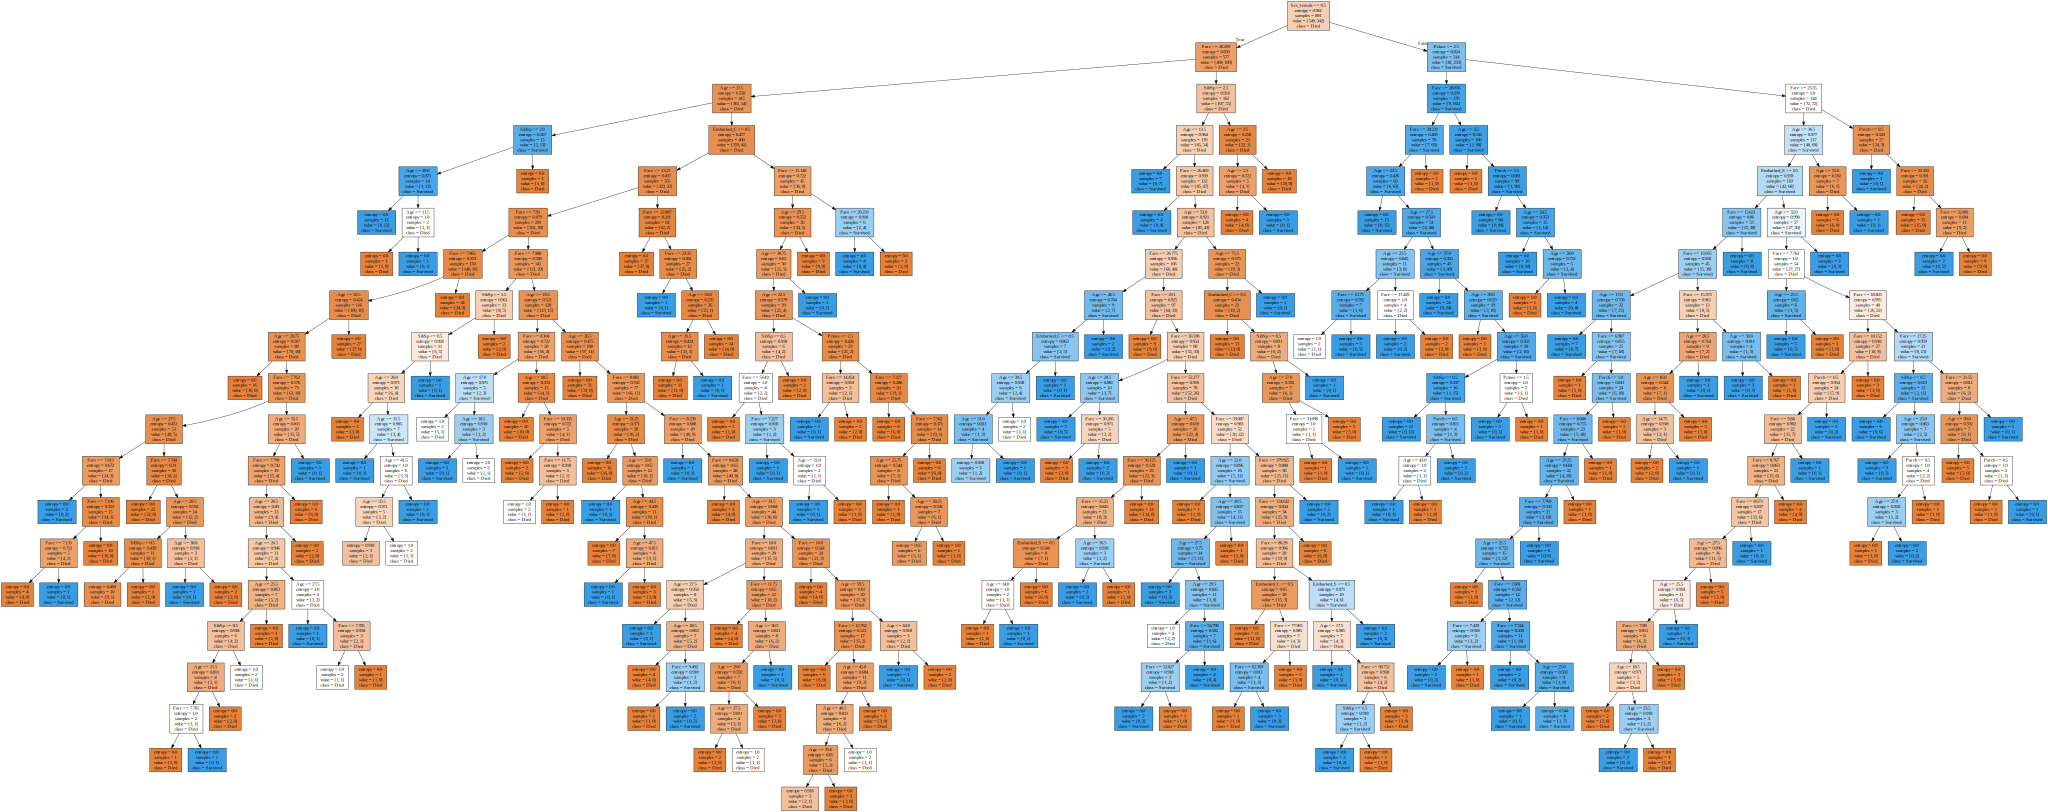

0.8203389830508474

In [17]:
import math as m
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn import tree
from IPython.display import HTML

style = "<style>svg{width:70% !important;height:70% !important;}</style>"
HTML(style)
titanic_data = pd.read_csv('data/titanic/train.csv')
titanic_data.head()
# PassengerId - ID пасажира
# Survived - выжил/не выжил
# Pclass - класс билета который он приобрел
# Name, Sex, Age - Имя, пол, возраст
# SibSp - Число сопутствующих пассажиров. (братьев и сестер / супругов на борту Титаника)
# Parch - родителей / детей на борту Титаника (pf parents / children aboard the Titinic)
# Ticket - номер билета
# Fare - Пасажирский тариф (плата за проезд)
# cabin - Номер кабины
# embarked - Порт к которому пристал (C = Cherbourg, Q = Queenstown, S = Southampton)

# Задача предсказать кто выжил, а кто не выжил.
## Базовая предобработка
# Поиск пропущенных значений в колонке.
titanic_data.isnull().sum()  # показывает сколько в каждой колонке пропущенных значений
titanic_data.shape
# Отбросим Name, PassengerId, Ticket и Cabin поскольку посчитаем их незначительными для обучения
X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis='columns')
X.head()
y = titanic_data.Survived
# Нужно также закодировать строки цифрами. Это называется label encoding если пол мужской 0 и женский 1
# или one-hot encoding когда Sex разбивается на sex_male и sex_female и они уже получают значение 0 и 1
# Подробнее: https://habr.com/ru/company/ods/blog/326418/#label-encoding
X = pd.get_dummies(X)  # Метод который самостоятельно переведет строковые значения в числовые
X.head()
# Заполним пропущенные значения
X = X.fillna({'Age': X.Age.median()})
X.isnull().sum()
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(X),
                                    class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))
# На графике сверху демонстрируется overfitting  или переобучение нашей модели. То есть дерево старается безошибочно классифицировать все наблюдения в DataFrame, а не вывести какое-то генерализованное правило (закономерность в данных), которое позволяет при новых неизвестных предсказывать более корректно.
# Пришло дерево к такому решению, поскольку мы не ограничили глубину дерева решений и оно обучалось вплоть до раздиления каждой комбинации разделения каждого элемента выборки.

# Проблема переобучения в данном случае в том что дерево из коробки не пытывается выявить некоторую закономерность в данных, а пытается классифицировать каждое наблюдение.

# Чтобы понять что модель отработает на незнакомом наборе данных, нужно протестировать модель на новом наборе данных, на которых она не обучалась.

# Проблему переобучения дерева можно решить ограничив его глубину (количество задаваемых вопросов для разбиения).
# Первое ограничить дерево рости как можно глубже.
# Второе показывать дереву 2 набора данных
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape
X_test.shape
# Попробуем сравнить насколько хорошо предсказывает дерево на train и test множествах.
# clf.score выдает число правильных ответов
clf.score(X, y)
# в 97 процентов случаев правильно классифицировали
clf.fit(X_train, y_train)
clf.score(X_train, y_train)
# Посмотрим соотвношение верных ответов отправив тестовую выборку которую классификатор не видел при обучении.
clf.score(X_test, y_test)
# И обнаружим что теперь только 0.76, соответсвенно на реальных данных точность сильно ниже и это признак переобучения.
# И одной из причин переобучения может быть то, что не ограничили количество ресурсов которе использует дерево.
# Попробуем ограничить длинну дерева 5-кой.
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)
clf.score(X_test, y_test)
# Можем заметить что на данных тренеровочных классификатор стал работать хуже, но на неизвестных данных лучше:
# Попробуем еще урезать:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)
clf.score(X_test, y_test)
# Как видим точность на тестовой выборке стала еще выше.


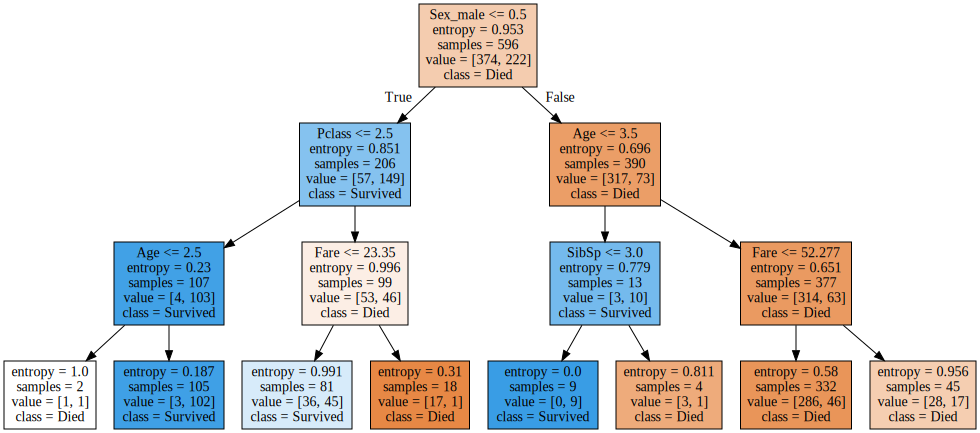

In [18]:
# Начало лекции 3.1
# Посмотрим что из себя представляет дерево обученное до глубины 3
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(X_train, y_train)
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(X),
                                    class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

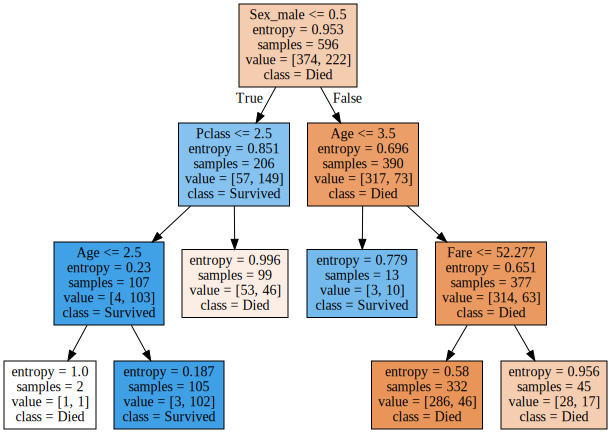

In [19]:
# Поменяем min_sample_split указывающий на минимальное количество частей для разбиения в целом.
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100)
clf.fit(X_train, y_train)
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(X),
                                    class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))
# Но можем наблюдать что samples=2 не убрался, для чего мы теперь добавим min_sample_leaf=10

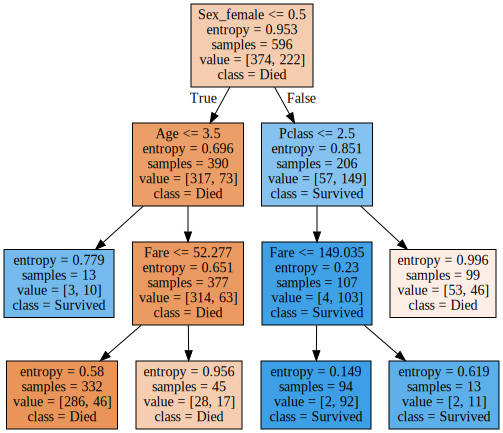

In [20]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100, min_samples_leaf=10)
clf.fit(X_train, y_train)
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=list(X),
                                    class_names=['Died', 'Survived'], filled=True))
display(SVG(graph.pipe(format='svg')))

Значения, необходимые для разделения узла:
1) min_impurity_decrease - ожидаемое минимальное уменьшение неопределенности (IG)
2) min_samples_split- минимальное количество сэмплов на входе узла
3) min_samples_leaf - минимальное количество сэмплов в выходном(ых) листе(ах)
Каждое деление узла уменьшает неопределенность

# По итогу балансровка между глубиной дерева, допустимым размером выборки после которого мы будем считать что можно сделать еще один сплит (min_samples_split) и допустимы размер выборки который мы можем отделить в отдельный исход (Значения, необходимые для разделения узла) и есть задача построителя модели для оптимизации метрик.